In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=89f5b450bb527b1c0956d5f54d835a8f05230dcfd42cbd5250db4b4a6f6b9361
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=361a60e468334eaeb1ae6d14423845f379537076255f8c9cebb6f1f71d34193d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Labeled Dataset/")
from data_loader import DataLoader


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#improved GAT+SBERT
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = '/content/drive/MyDrive/Labeled Dataset/long_sentiments.csv'
df = pd.read_csv(path)

# class weights
class_counts = df['label'].value_counts().to_dict()
total_samples = len(df)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(3)], dtype=torch.float).to(device)

# Initialize Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
parent_embeddings = sbert_model.encode(df['body_parent'].tolist())
child_embeddings = sbert_model.encode(df['body_child'].tolist())

# Create node features and edges

# Sentence-BERT embeddings
parent_embeddings = sbert_model.encode(df['body_parent'].tolist())
child_embeddings = sbert_model.encode(df['body_child'].tolist())

# Convert to PyTorch tensors and concatenate sentiment scores
node_features = torch.cat((
    torch.tensor(parent_embeddings, dtype=torch.float),
    torch.tensor(child_embeddings, dtype=torch.float),
    torch.tensor(df['sentiment_parent'].values.reshape(-1, 1), dtype=torch.float),
    torch.tensor(df['sentiment_child'].values.reshape(-1, 1), dtype=torch.float)
), dim=1)

# Create edges
all_msg_ids = pd.concat([df['msg_id_parent'], df['msg_id_child']]).unique()
msg_to_int = {msg: i for i, msg in enumerate(all_msg_ids)}
edges = torch.tensor([(msg_to_int[parent], msg_to_int[child]) for parent, child in zip(df['msg_id_parent'], df['msg_id_child'])], dtype=torch.long).t().contiguous()

# Labels and masks
labels = torch.tensor(df['label'].values, dtype=torch.long)
n_samples = len(df)
train_mask = torch.zeros(n_samples, dtype=torch.bool)
val_mask = torch.zeros(n_samples, dtype=torch.bool)
test_mask = torch.zeros(n_samples, dtype=torch.bool)

train_indices = torch.randperm(n_samples)[:int(0.7 * n_samples)]
val_indices = torch.randperm(n_samples)[int(0.7 * n_samples):int(0.85 * n_samples)]
test_indices = torch.randperm(n_samples)[int(0.85 * n_samples):]
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True


data = Data(x=node_features, edge_index=edges, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
from torch_geometric.data import DataLoader

# Hybrid Model definition
class HybridModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HybridModel, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=8, dropout=0.6)
        self.gat2 = GATConv(64 * 8, 64, heads=1, concat=False, dropout=0.6)
        self.fc = nn.Linear(64 + in_channels, out_channels)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x_gat = F.dropout(x, p=0.6, training=self.training)
        x_gat = F.elu(self.gat1(x_gat, edge_index))
        x_gat = F.dropout(x_gat, p=0.6, training=self.training)
        x_gat = self.gat2(x_gat, edge_index)
        x_concat = torch.cat((x_gat, x), dim=1)
        x_out = self.fc(x_concat)
        return F.log_softmax(x_out, dim=1)


model = HybridModel(node_features.shape[1], 3).to(device)
data = data.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# early stopping logic
PATIENCE = 20
best_val_loss = float('inf')
counter = 0

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=weights)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(data, mask):
    model.eval()
    with torch.no_grad():
        preds = model(data).max(dim=1)[1]
    correct = preds[mask].eq(data.y[mask]).sum().item()
    return correct / mask.sum().item(), preds

train_accuracies = []
val_accuracies = []
losses = []

for epoch in range(200):
    loss = train(data)
    train_acc = evaluate(data, data.train_mask)[0]
    val_acc = evaluate(data, data.val_mask)[0]

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    losses.append(loss)

    print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if loss < best_val_loss:
        best_val_loss = loss
        counter = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early Stopping triggered.")
            break


acc, predictions = evaluate(data, data.test_mask)
predictions = predictions[data.test_mask].cpu().numpy()
ground_truth = data.y[data.test_mask].cpu().numpy()


print("\nClassification Report:")
print(classification_report(ground_truth, predictions))

# Confusion matrix



from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix",
           ylabel="True label",
           xlabel="Predicted label")

    plt.show()


plot_confusion_matrix(ground_truth, predictions, classes=[0, 1, 2])


torch.save(model.state_dict(), "best_model.pth")

print("Model and results saved.")

# Optionally, plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()




ModuleNotFoundError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path of dataset
path = '/content/drive/MyDrive/Labeled Dataset/long_sentiments.csv'
df = pd.read_csv(path)

# Calculate class weights for the loss function
class_counts = df['label'].value_counts().to_dict()
total_samples = len(df)
class_weights = {
    cls: total_samples / count for cls, count in class_counts.items()
}
weights = torch.tensor([class_weights[i] for i in range(3)], dtype=torch.float).to(device)

# Initialize Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
parent_embeddings = sbert_model.encode(df['body_parent'].tolist())
child_embeddings = sbert_model.encode(df['body_child'].tolist())

.

# Revised Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HybridModel, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=8, dropout=0.6)
        self.gat2 = GATConv(64 * 8, 64, heads=1, concat=False, dropout=0.6)
        self.fc = nn.Linear(64 + in_channels, out_channels)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x_gat = F.dropout(x, p=0.6, training=self.training)
        x_gat = F.elu(self.gat1(x_gat, edge_index))
        x_gat = F.dropout(x_gat, p=0.6, training=self.training)
        x_gat = self.gat2(x_gat, edge_index)

        x_concat = torch.cat((x_gat, x), dim=1)
        x_out = self.fc(x_concat)

        return F.log_softmax(x_out, dim=1)


model = HybridModel(node_features.shape[1], 3).to(device)



In [ ]:
#GAT alone
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
import numpy as np

# Set random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = '/content/drive/MyDrive/Labeled Dataset/long_sentiments.csv'
df = pd.read_csv(path)

# Class weighting
class_counts = df['label'].value_counts().to_dict()
total_samples = len(df)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(3)], dtype=torch.float).to(device)

# Feature Normalization
scaler = StandardScaler()
node_features = np.stack((df['sentiment_parent'].values, df['sentiment_child'].values), axis=1)
node_features = scaler.fit_transform(node_features)


msg_to_int = {msg: i for i, msg in enumerate(pd.concat([df['msg_id_parent'], df['msg_id_child']]).unique())}
edges = torch.tensor([(msg_to_int[parent], msg_to_int[child]) for parent, child in zip(df['msg_id_parent'], df['msg_id_child'])], dtype=torch.long).t().contiguous()

node_features = torch.tensor(node_features, dtype=torch.float)
labels = torch.tensor(df['label'].values, dtype=torch.long)

data = Data(x=node_features, edge_index=edges, y=labels).to(device)

# Model
class GATClassifier(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(in_channels, 64, heads=8, dropout=0.6)
        self.conv2 = GATConv(64 * 8, 32, heads=4, dropout=0.6)
        self.conv3 = GATConv(32 * 4, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, data.edge_index)
        return F.log_softmax(x, dim=1)

model = GATClassifier(node_features.shape[1], 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.7)

# Training
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y, weight=weights)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation
def evaluate(data):
    model.eval()
    with torch.no_grad():
        preds = model(data).max(dim=1)[1]
    return preds

# Main Loop
for epoch in range(200):
    loss = train(data)
    preds = evaluate(data)
    scheduler.step()
    print(f"Epoch: {epoch + 1}, Loss: {loss}")

# Evaluation
preds = evaluate(data).cpu().numpy()
labels = data.y.cpu().numpy()

print("\nClassification Report:")
print(classification_report(labels, preds))


Epoch: 1, Loss: 1.3953735828399658
Epoch: 2, Loss: 1.4017583131790161
Epoch: 3, Loss: 1.3502089977264404
Epoch: 4, Loss: 1.304420828819275
Epoch: 5, Loss: 1.2966735363006592
Epoch: 6, Loss: 1.2937790155410767
Epoch: 7, Loss: 1.263827919960022
Epoch: 8, Loss: 1.2281451225280762
Epoch: 9, Loss: 1.231244683265686
Epoch: 10, Loss: 1.22014582157135
Epoch: 11, Loss: 1.2045432329177856
Epoch: 12, Loss: 1.1898020505905151
Epoch: 13, Loss: 1.1845554113388062
Epoch: 14, Loss: 1.1802911758422852
Epoch: 15, Loss: 1.161356806755066
Epoch: 16, Loss: 1.1575177907943726
Epoch: 17, Loss: 1.1552152633666992
Epoch: 18, Loss: 1.1366277933120728
Epoch: 19, Loss: 1.1308834552764893
Epoch: 20, Loss: 1.1349384784698486
Epoch: 21, Loss: 1.134308934211731
Epoch: 22, Loss: 1.1238973140716553
Epoch: 23, Loss: 1.1200578212738037
Epoch: 24, Loss: 1.1180676221847534
Epoch: 25, Loss: 1.1120542287826538
Epoch: 26, Loss: 1.1115210056304932
Epoch: 27, Loss: 1.1109188795089722
Epoch: 28, Loss: 1.1114052534103394
Epoch: 2

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.7 MB/s eta 0:00:00


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1, Loss: 2.0225, Train Acc: 0.3526, Val Acc: 0.3593
Epoch: 2, Loss: 1.8711, Train Acc: 0.3458, Val Acc: 0.3502
Epoch: 3, Loss: 1.8656, Train Acc: 0.3468, Val Acc: 0.3502
Epoch: 4, Loss: 1.7644, Train Acc: 0.3503, Val Acc: 0.3502
Epoch: 5, Loss: 1.7083, Train Acc: 0.3779, Val Acc: 0.3677
Epoch: 6, Loss: 1.6624, Train Acc: 0.4622, Val Acc: 0.4557
Epoch: 7, Loss: 1.6443, Train Acc: 0.4700, Val Acc: 0.4450
Epoch: 8, Loss: 1.5557, Train Acc: 0.4477, Val Acc: 0.4205
Epoch: 9, Loss: 1.5360, Train Acc: 0.4253, Val Acc: 0.4006
Epoch: 10, Loss: 1.5436, Train Acc: 0.3784, Val Acc: 0.3869
Epoch: 11, Loss: 1.4519, Train Acc: 0.3571, Val Acc: 0.3647
Epoch: 12, Loss: 1.4419, Train Acc: 0.3550, Val Acc: 0.3624
Epoch: 13, Loss: 1.4151, Train Acc: 0.3568, Val Acc: 0.3631
Epoch: 14, Loss: 1.3844, Train Acc: 0.3609, Val Acc: 0.3693
Epoch: 15, Loss: 1.3534, Train Acc: 0.3701, Val Acc: 0.3777
Epoch: 16, Loss: 1.3637, Train Acc: 0.3891, Val Acc: 0.3899
Epoch: 17, Loss: 1.3721, Train Acc: 0.4092, Val A

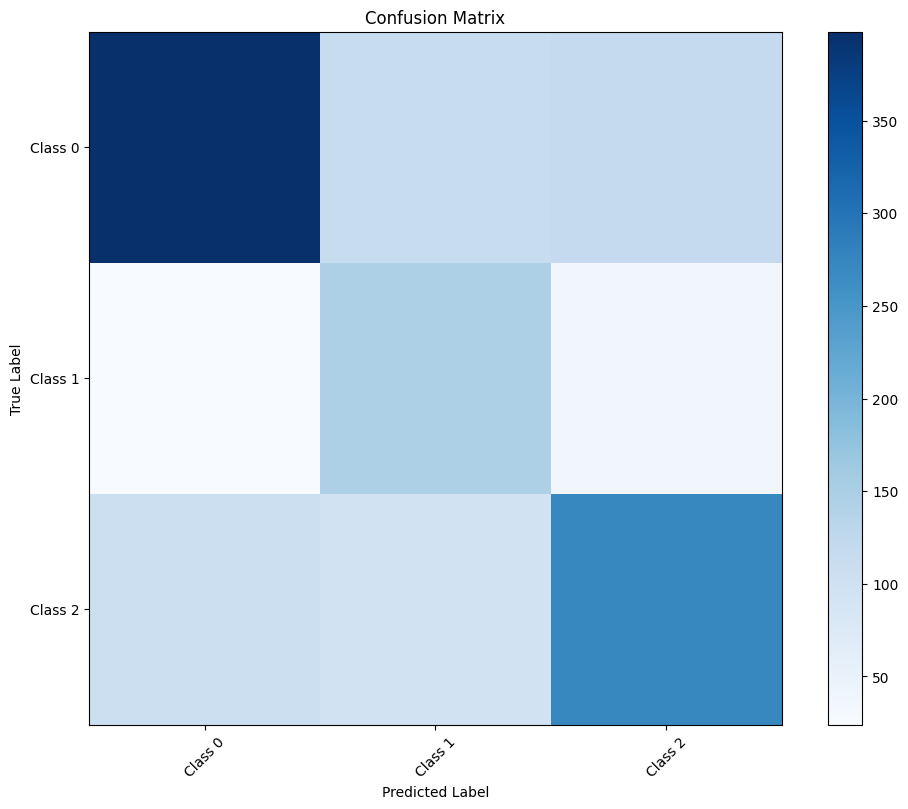

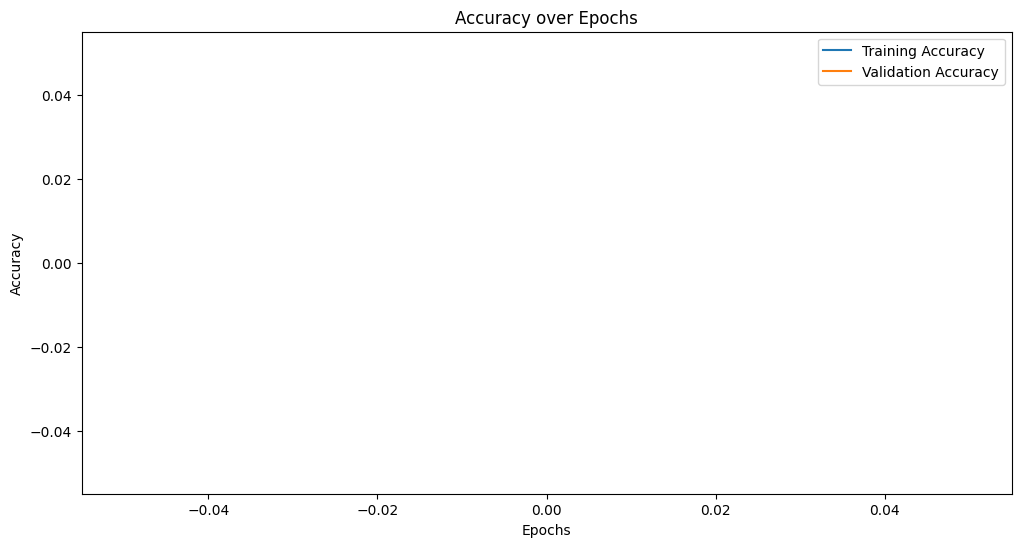

In [ ]:
#Roberta
#Baseline models
import torch
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = '/content/drive/MyDrive/Labeled Dataset/long_sentiments.csv'
df = pd.read_csv(path)


class_counts = df['label'].value_counts().to_dict()
total_samples = len(df)
class_weights = {
    cls: total_samples / count for cls, count in class_counts.items()
}
weights = torch.tensor([class_weights[i] for i in range(3)], dtype=torch.float).to(device)


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base').to(device)


def get_embeddings(sentences, model, tokenizer):
    model.eval()
    embeddings = []
    BATCH_SIZE = 32
    for i in range(0, len(sentences), BATCH_SIZE):
        batch_sentences = sentences[i:i + BATCH_SIZE]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.extend(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.array(embeddings)

parent_embeddings = get_embeddings(df['body_parent'].tolist(), roberta_model, tokenizer)
child_embeddings = get_embeddings(df['body_child'].tolist(), roberta_model, tokenizer)

all_msg_ids = pd.concat([df['msg_id_parent'], df['msg_id_child']]).unique()
msg_to_int = {msg: i for i, msg in enumerate(all_msg_ids)}
edges = torch.tensor([(msg_to_int[parent], msg_to_int[child]) for parent, child in zip(df['msg_id_parent'], df['msg_id_child'])], dtype=torch.long).t().contiguous()

node_features = torch.cat((torch.tensor(parent_embeddings, dtype=torch.float),
                           torch.tensor(child_embeddings, dtype=torch.float),
                           torch.tensor(df['sentiment_parent'].values.reshape(-1,1), dtype=torch.float),
                           torch.tensor(df['sentiment_child'].values.reshape(-1,1), dtype=torch.float)), dim=1)
labels = torch.tensor(df['label'].values, dtype=torch.long)


train_end = int(0.7 * total_samples)
val_end = train_end + int(0.15 * total_samples)
indices = torch.randperm(total_samples)
train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_mask = torch.zeros(total_samples, dtype=torch.bool).index_fill_(0, train_indices, True)
val_mask = torch.zeros(total_samples, dtype=torch.bool).index_fill_(0, val_indices, True)
test_mask = torch.zeros(total_samples, dtype=torch.bool).index_fill_(0, test_indices, True)

data = Data(x=node_features, edge_index=edges, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask).to(device)

class GATClassifier(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(in_channels, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x = F.dropout(data.x, p=0.5, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

model = GATClassifier(node_features.shape[1], 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Implement early stopping logic
PATIENCE = 20
best_val_acc = 0
counter = 0
train_accuracies = []
val_accuracies = []

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=weights)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(data, mask):
    model.eval()
    with torch.no_grad():
        preds = model(data).max(dim=1)[1]
    correct = preds[mask].eq(data.y[mask]).sum().item()
    return correct / mask.sum().item(), preds

for epoch in range(200):
    loss = train(data)
    train_acc = evaluate(data, data.train_mask)[0]
    val_acc = evaluate(data, data.val_mask)[0]
    print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early Stopping triggered.")
            break

acc, predictions = evaluate(data, data.test_mask)
predictions = predictions[data.test_mask].cpu().numpy()
ground_truth = data.y[data.test_mask].cpu().numpy()

print("\nClassification Report:")
print(classification_report(ground_truth, predictions))


cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ["Class 0", "Class 1", "Class 2"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.savefig("confusion_matrix.jpeg", format="jpeg")

plt.show()


plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#Baseline models
#BERT uncased/base
import torch
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


scaler = GradScaler()


df = pd.read_csv('/content/drive/MyDrive/Labeled Dataset/climate_agreement.csv')


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and padding
max_length = 128
df['tokens_parent'] = df['body_parent'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))
df['tokens_child'] = df['body_child'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))
df['tokens_parent'] = df['tokens_parent'].apply(lambda x: x + [0] * (max_length - len(x)))
df['tokens_child'] = df['tokens_child'].apply(lambda x: x + [0] * (max_length - len(x)))

# Train-Test Split
train, test = train_test_split(df, test_size=0.2)
train_x_parent = torch.tensor(train['tokens_parent'].tolist())
train_x_child = torch.tensor(train['tokens_child'].tolist())
train_y = torch.tensor(train['label'].tolist())
test_x_parent = torch.tensor(test['tokens_parent'].tolist())
test_x_child = torch.tensor(test['tokens_child'].tolist())
test_y = torch.tensor(test['label'].tolist())


train_data = TensorDataset(train_x_parent, train_x_child, train_y)
train_loader = DataLoader(train_data, batch_size=4)
test_data = TensorDataset(test_x_parent, test_x_child, test_y)
test_loader = DataLoader(test_data, batch_size=4)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=train['label'])
class_weights = torch.tensor(class_weights).float().to(device)

# Training Loop with Gradient Accumulation and Mixed Precision
accumulation_steps = 4
for epoch in range(3):
    model.train()
    for i, (x_parent, x_child, y) in enumerate(train_loader):
        x_parent, x_child, y = x_parent.to(device), x_child.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs_parent = model(x_parent, labels=None)[0]
            outputs_child = model(x_child, labels=None)[0]
            outputs_combined = (outputs_parent + outputs_child) / 2

            loss = CrossEntropyLoss(weight=class_weights)(outputs_combined, y)

        # Gradient Accumulation
        scaler.scale(loss).backward()

        if (i+1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()

        if i % 10 == 0:
            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}')



# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_parent, x_child, y in test_loader:
        x_parent, x_child, y = x_parent.to(device), x_child.to(device), y.to(device)
        outputs_parent = model(x_parent)[0]
        outputs_child = model(x_child)[0]
        outputs_combined = (outputs_parent + outputs_child) / 2

        _, predicted = torch.max(outputs_combined.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Classification Report
print(classification_report(all_labels, all_preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Iteration: 0, Loss: 1.1107900142669678
Epoch: 0, Iteration: 10, Loss: 1.8481004238128662
Epoch: 0, Iteration: 20, Loss: 1.90625
Epoch: 0, Iteration: 30, Loss: 1.5911160707473755
Epoch: 0, Iteration: 40, Loss: 1.2287205457687378
Epoch: 0, Iteration: 50, Loss: 1.1356794834136963
Epoch: 0, Iteration: 60, Loss: 0.9695456027984619
Epoch: 0, Iteration: 70, Loss: 1.2504440546035767
Epoch: 0, Iteration: 80, Loss: 1.1584497690200806
Epoch: 0, Iteration: 90, Loss: 1.3733052015304565
Epoch: 0, Iteration: 100, Loss: 0.9313027858734131
Epoch: 0, Iteration: 110, Loss: 1.2123568058013916
Epoch: 0, Iteration: 120, Loss: 1.1374573707580566
Epoch: 0, Iteration: 130, Loss: 1.2286139726638794
Epoch: 0, Iteration: 140, Loss: 1.0654475688934326
Epoch: 0, Iteration: 150, Loss: 0.957149863243103
Epoch: 0, Iteration: 160, Loss: 0.8964385986328125
Epoch: 0, Iteration: 170, Loss: 1.2857216596603394
Epoch: 0, Iteration: 180, Loss: 1.2467820644378662
Epoch: 0, Iteration: 190, Loss: 0.8950372338294983
Epo